In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
pd.set_option('mode.chained_assignment', None)  # silence SettingWithCopy warnings


In [5]:


candidates = [
    "Online Retail.xlsx",
    "OnlineRetail.xlsx",
    "online retail.xlsx",
    "Online Retail (1).xlsx"
]

df = None
last_err = None
for path in candidates:
    try:
        df = pd.read_excel(path)
        print(f"Loaded: {path}")
        break
    except Exception as e:
        last_err = e

if df is None:
    raise FileNotFoundError(
        f"Could not find any of: {candidates}\n"
        f"Last error: {last_err}"
)

df.head()


Loaded: Online Retail.xlsx


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,"17,850.00",United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,"17,850.00",United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom


In [9]:

df = df.dropna(subset=['CustomerID'])

# 2) Remove cancellations (InvoiceNo starting with 'C')
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df = df[~df['InvoiceNo'].str.startswith('C')]

# 3) Keep only positive quantities & prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# 4) Ensure InvoiceDate is datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 5) Remove duplicates (optional)
df = df.drop_duplicates()

print(df.shape)
df.head()


(392692, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,"17,850.00",United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,"17,850.00",United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom


In [11]:

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df[['InvoiceNo','CustomerID','InvoiceDate','Quantity','UnitPrice','TotalPrice']].head()


,InvoiceNo,CustomerID,InvoiceDate,Quantity,UnitPrice,TotalPrice
0,536365,"17,850.00",2010-12-01 08:26:00,6,2.55,15.30
1,536365,"17,850.00",2010-12-01 08:26:00,6,3.39,20.34
2,536365,"17,850.00",2010-12-01 08:26:00,8,2.75,22.00
3,536365,"17,850.00",2010-12-01 08:26:00,6,3.39,20.34
4,536365,"17,850.00",2010-12-01 08:26:00,6,3.39,20.34


In [13]:

ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (ref_date - x.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('TotalPrice', 'sum')
).reset_index()

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,"12,346.00",326,1,"77,183.60"
1,"12,347.00",2,7,"4,310.00"
2,"12,348.00",75,4,"1,797.24"
3,"12,349.00",19,1,"1,757.55"
4,"12,350.00",310,1,334.40


In [19]:

rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1]).astype(int)


rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method="first"), 4, labels=[1,2,3,4]).astype(int)

rfm['M_score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4]).astype(int)

# Combine
rfm['RFM_Segment'] = (
    rfm['R_score'].astype(str) +
    rfm['F_score'].astype(str) +
    rfm['M_score'].astype(str)
)

rfm['RFM_Score'] = rfm[['R_score','F_score','M_score']].sum(axis=1)

rfm.head(10)


,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Segment,RFM_Score
0,"12,346.00",326,1,"77,183.60",1,1,4,114,6
1,"12,347.00",2,7,"4,310.00",4,4,4,444,12
2,"12,348.00",75,4,"1,797.24",2,3,4,234,9
3,"12,349.00",19,1,"1,757.55",3,1,4,314,8
4,"12,350.00",310,1,334.40,1,1,2,112,4
5,"12,352.00",36,8,"2,506.04",3,4,4,344,11
6,"12,353.00",204,1,89.00,1,1,1,111,3
7,"12,354.00",232,1,"1,079.40",1,1,3,113,5
8,"12,355.00",214,1,459.40,1,1,2,112,4
9,"12,356.00",23,3,"2,811.43",3,3,4,334,10


In [23]:


def assign_segment(row):
    r, f = row['R_score'], row['F_score']
    if r >= 4 and f >= 3:
        return "Champions"
    elif r >= 3 and f >= 3:
        return "Loyal"
    elif r >= 4 and f == 2:
        return "Potential Loyalist"
    elif r == 4 and f == 1:
        return "New Customers"
    elif r == 3 and f == 1:
        return "Promising"
    elif r == 2 and f in (2,3):
        return "Need Attention"
    elif r == 1 and f >= 2:
        return "At Risk"
    else:
        return "Lost"

rfm['Segment'] = rfm.apply(assign_segment, axis=1)

# Quick view
rfm[['CustomerID','Recency','Frequency','Monetary','R_score','F_score','M_score','RFM_Segment','RFM_Score','Segment']].head(15)


,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Segment,RFM_Score,Segment
0,"12,346.00",326,1,"77,183.60",1,1,4,114,6,Lost
1,"12,347.00",2,7,"4,310.00",4,4,4,444,12,Champions
2,"12,348.00",75,4,"1,797.24",2,3,4,234,9,Need Attention
3,"12,349.00",19,1,"1,757.55",3,1,4,314,8,Promising
4,"12,350.00",310,1,334.40,1,1,2,112,4,Lost
5,"12,352.00",36,8,"2,506.04",3,4,4,344,11,Loyal
6,"12,353.00",204,1,89.00,1,1,1,111,3,Lost
7,"12,354.00",232,1,"1,079.40",1,1,3,113,5,Lost
8,"12,355.00",214,1,459.40,1,1,2,112,4,Lost
9,"12,356.00",23,3,"2,811.43",3,3,4,334,10,Loyal


In [25]:

seg_counts = rfm['Segment'].value_counts().sort_values(ascending=False)
seg_monetary = rfm.groupby('Segment')['Monetary'].agg(['count','mean','sum']).sort_values('sum', ascending=False)

print("Counts by Segment:\n", seg_counts, "\n")
print("Monetary by Segment:\n", seg_monetary)


Counts by Segment:
 Segment
Lost                  1218
Champions              891
Loyal                  632
Need Attention         613
At Risk                565
Promising              185
Potential Loyalist     160
New Customers           74
Name: count, dtype: int64 

Monetary by Segment:
                     count     mean          sum
Segment                                        
Champions             891 5,543.61 4,939,358.00
Loyal                 632 2,602.49 1,644,772.10
Lost                 1218   753.51   917,771.45
Need Attention        613   940.17   576,321.19
At Risk               565   805.45   455,080.93
Potential Loyalist    160 1,639.64   262,341.65
Promising             185   362.11    66,990.43
New Customers          74   332.07    24,573.14


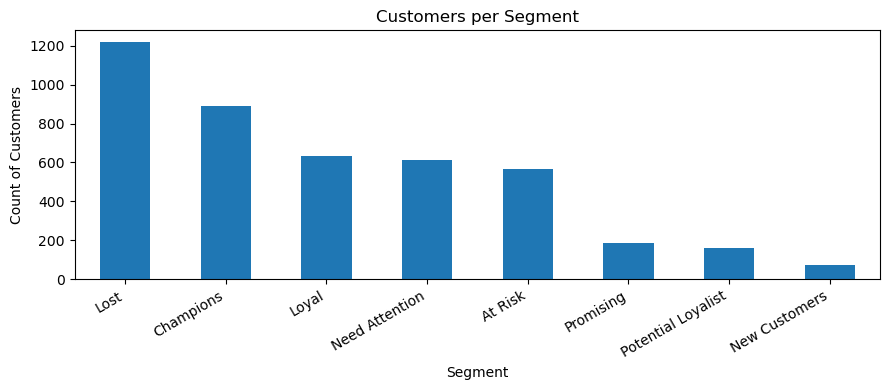

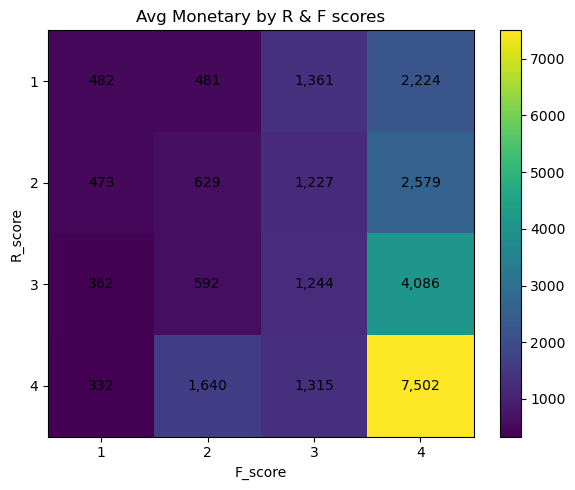

In [33]:



plt.figure(figsize=(9,4))
rfm['Segment'].value_counts().plot(kind='bar')
plt.title("Customers per Segment")
plt.xlabel("Segment")
plt.ylabel("Count of Customers")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


pivot = rfm.pivot_table(index='R_score', columns='F_score', values='Monetary', aggfunc='mean')

plt.figure(figsize=(6,5))
im = plt.imshow(pivot.values, aspect='auto')
plt.colorbar(im)
plt.xticks(ticks=range(len(pivot.columns)), labels=pivot.columns)
plt.yticks(ticks=range(len(pivot.index)), labels=pivot.index)
plt.title("Avg Monetary by R & F scores")
plt.xlabel("F_score")
plt.ylabel("R_score")

# Annotate cells
for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        val = pivot.values[i, j]
        if not np.isnan(val):
            plt.text(j, i, f"{val:,.0f}", ha='center', va='center')

plt.tight_layout()
plt.show()


In [35]:

seg_counts = rfm['Segment'].value_counts().sort_values(ascending=False)


seg_monetary = rfm.groupby('Segment')['Monetary'].agg(['count','mean','sum']).sort_values('sum', ascending=False)

print("Counts by Segment:\n")
print(seg_counts, "\n")
print("Monetary by Segment:\n")
print(seg_monetary, "\n")


rfm.to_csv("rfm_table.csv", index=False)
seg_counts.to_csv("rfm_segment_counts.csv")
seg_monetary.to_csv("rfm_segment_monetary.csv")

print("✅ Files saved: rfm_table.csv, rfm_segment_counts.csv, rfm_segment_monetary.csv")


Counts by Segment:

Segment
Lost                  1218
Champions              891
Loyal                  632
Need Attention         613
At Risk                565
Promising              185
Potential Loyalist     160
New Customers           74
Name: count, dtype: int64 

Monetary by Segment:

                    count     mean          sum
Segment                                        
Champions             891 5,543.61 4,939,358.00
Loyal                 632 2,602.49 1,644,772.10
Lost                 1218   753.51   917,771.45
Need Attention        613   940.17   576,321.19
At Risk               565   805.45   455,080.93
Potential Loyalist    160 1,639.64   262,341.65
Promising             185   362.11    66,990.43
New Customers          74   332.07    24,573.14 

✅ Files saved: rfm_table.csv, rfm_segment_counts.csv, rfm_segment_monetary.csv


In [37]:
# Marketing strategy suggestions

for seg in rfm['Segment'].unique():
    if seg == "Champions":
        print("Champions → Reward them with loyalty programs, VIP offers.")
    elif seg == "Loyal":
        print("Loyal → Offer new arrivals, referral benefits.")
    elif seg == "Potential Loyalist":
        print("Potential Loyalist → Encourage repeat purchase with discounts.")
    elif seg == "New Customers":
        print("New Customers → Send welcome emails, introduce bundles.")
    elif seg == "Promising":
        print("Promising → Personalized recommendations to build loyalty.")
    elif seg == "Need Attention":
        print("Need Attention → Offer targeted deals, reminders.")
    elif seg == "At Risk":
        print("At Risk → Strong re-engagement offers, feedback surveys.")
    elif seg == "Lost":
        print("Lost → Win-back campaigns, heavy discounts.")


Lost → Win-back campaigns, heavy discounts.
Champions → Reward them with loyalty programs, VIP offers.
Need Attention → Offer targeted deals, reminders.
Promising → Personalized recommendations to build loyalty.
Loyal → Offer new arrivals, referral benefits.
Potential Loyalist → Encourage repeat purchase with discounts.
At Risk → Strong re-engagement offers, feedback surveys.
New Customers → Send welcome emails, introduce bundles.
